In [1]:
#! pip install lightgbm
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1
#!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [24]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn import metrics
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.stats import skew
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score, r2_score, f1_score,\
roc_auc_score,mean_absolute_error,mean_absolute_percentage_error,max_error


In [4]:
data_fin_imprt=pd.read_csv("final.csv",  delimiter=',')



In [5]:
data_fin_imprt.head(15)

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,3.044522,4.955827,10.366309,6,1.791759,7.581210,1960,4.727388,6.461468,0.000000,...,False,False,False,True,False,False,False,False,True,False
1,3.044522,4.394449,9.360741,5,1.945910,7.581720,1961,0.000000,6.150603,4.976734,...,False,False,False,True,False,False,False,False,True,False
2,3.044522,4.406719,9.565775,6,1.945910,7.580189,1958,4.691348,6.828712,0.000000,...,False,False,False,True,False,False,False,False,True,False
3,3.044522,4.543295,9.320181,7,1.791759,7.585281,1968,0.000000,6.971669,0.000000,...,False,False,False,True,False,False,False,False,True,False
4,4.110874,4.317488,9.534668,5,1.791759,7.599902,1998,0.000000,6.674561,0.000000,...,False,False,False,True,False,False,False,False,True,False
5,4.110874,4.369448,9.208238,6,1.945910,7.600402,1998,3.044522,6.401917,0.000000,...,False,False,False,True,False,False,False,False,True,False
6,4.795791,3.737670,8.501267,8,1.791759,7.601902,2001,0.000000,6.424869,0.000000,...,False,False,False,True,False,False,False,False,True,False
7,4.795791,3.784190,8.518392,8,1.791759,7.597396,1992,0.000000,5.575949,0.000000,...,False,False,False,True,False,False,False,False,True,False
8,4.795791,3.688879,8.592301,8,1.791759,7.598900,1996,0.000000,7.074117,0.000000,...,False,False,False,True,False,False,False,False,True,False
9,4.110874,4.110874,8.922792,7,1.791759,7.600902,1999,0.000000,0.000000,0.000000,...,False,False,False,True,False,False,False,False,True,False


In [6]:

x=data_fin_imprt.drop('SalePrice',axis=1)
y=data_fin_imprt['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [7]:
lgb_mod = lgb.LGBMRegressor()
lgb_mod.fit(x_train, y_train)
lgb_pred = lgb_mod.predict(x_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3753
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 197
[LightGBM] [Info] Start training from score 12.011814


In [9]:
lgb_mod_sc=lgb_mod.score(x_train,y_train)
print('LGBM Regression Model Score  : ',round(lgb_mod_sc,3))
r2=r2_score(y_test,lgb_pred)# computing and displaying the R.Sq of the model
print('R Sq. Value : ',round(r2,2))
rfr_adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-x.shape[1]-1)
print('Adjusted R Sq. Value is : ', round(rfr_adj_r2,3))
mean_sq=mean_squared_error(y_test,lgb_pred)# computing and displaying the Mean square error of the model
print('Mean Square Error is : ', round(mean_sq,3))
lin_mse=mean_squared_error(y_test,lgb_pred)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Square Error is : ', round(lin_rmse,3))
lin_mae=mean_absolute_error(y_test, lgb_pred)
print('Mean Absoulue Error is : ', round(lin_mae,3))
scores_cvs = cross_val_score(lgb_mod, x, y,scoring='r2' ,cv=5)
print("Accuracy :",round(scores_cvs.mean()*100,2),"%") # Accuracy of model

LGBM Regression Model Score  :  0.978
R Sq. Value :  0.93
Adjusted R Sq. Value is :  0.922
Mean Square Error is :  0.013
Root Mean Square Error is :  0.114
Mean Absoulue Error is :  0.078
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3757
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 200
[LightGBM] [Info] Start training from score 12.004380
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

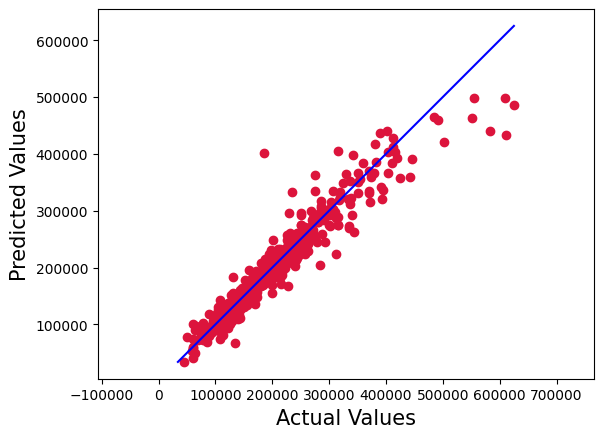

In [10]:
Actual_Price=np.expm1(y_test)
Predicted_Price=np.expm1(lgb_pred)
plt.scatter(Actual_Price, Predicted_Price, c='crimson')
p1 = max(max(Predicted_Price), max(Actual_Price))
p2 = min(min(Predicted_Price), min(Actual_Price))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

<ipython-input-11-3a24dc4c93af>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot((y_test-lgb_pred),bins=100);


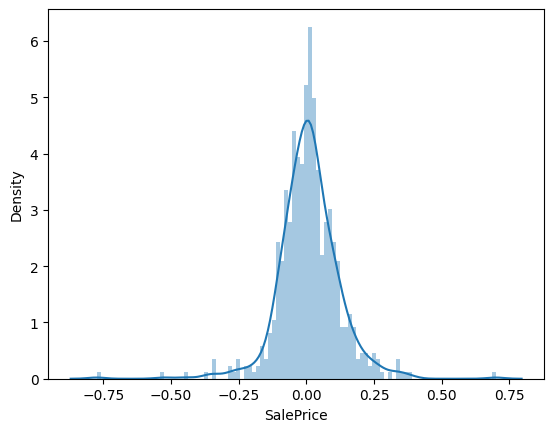

In [11]:
sb.distplot((y_test-lgb_pred),bins=100);

In [15]:
# LGBM optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    # Train model
    model = lgb.LGBMRegressor(**param)
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)])

    # Predict and evaluate
    predict = model.predict(x_test)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    return rmse  # Minimize RMSE

# Run Optuna optimization
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
# Print best hyperparameters
print("Best RMSE:", study.best_value)
print("Best Hyperparameters:", study.best_params)


[I 2025-03-07 00:54:48,065] A new study created in memory with name: no-name-6a6b5851-253e-489c-8136-ef64f246d355


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 147
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.011814
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-07 00:54:48,617] Trial 0 finished with value: 0.11312982577446534 and parameters: {'learning_rate': 0.07550212031591498, 'num_leaves': 416, 'subsample': 0.5337546323951612, 'colsample_bytree': 0.7609408044406207, 'min_data_in_leaf': 65}. Best is trial 0 with value: 0.11312982577446534.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:54:49,123] Trial 1 finished with value: 0.1810746410339068 and parameters: {'learning_rate': 0.013946263769422861, 'num_leaves': 848, 'subsample': 0.06578470844476624, 'colsample_bytree': 0.5492031798803296, 'min_data_in_leaf': 69}. Best is trial 0 with value: 0.11312982577446534.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:54:49,764] Trial 2 finished with value: 0.39936068159026183 and parameters: {'learning_rate': 0.0011634354776734871, 'num_leaves': 53, 'subsample': 0.8921532038233345, 'colsample_bytree': 0.1372101416045846, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.11312982577446534.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:54:50,414] Trial 3 finished with value: 0.14870316380617296 and parameters: {'learning_rate': 0.019056944271352485, 'num_leaves': 884, 'subsample': 0.8306447291942317, 'colsample_bytree': 0.6533687724605938, 'min_data_in_leaf': 54}. Best is trial 0 with value: 0.11312982577446534.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:54:50,827] Trial 4 finished with value: 0.28483657967362735 and parameters: {'learning_rate': 0.005910835588466618, 'num_leaves': 797, 'subsample': 0.4012078037116687, 'colsample_bytree': 0.9296345960354157, 'min_data_in_leaf': 95}. Best is trial 0 with value: 0.11312982577446534.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:54:51,714] Trial 5 finished with value: 0.1123690375549578 and parameters: {'learning_rate': 0.0958964937285763, 'num_leaves': 635, 'subsample': 0.515904625064678, 'colsample_bytree': 0.9705336983961048, 'min_data_in_leaf': 33}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[Light

[I 2025-03-07 00:54:52,689] Trial 6 finished with value: 0.11247772513804637 and parameters: {'learning_rate': 0.06909972412090161, 'num_leaves': 668, 'subsample': 0.6086826025680749, 'colsample_bytree': 0.7596473023489408, 'min_data_in_leaf': 25}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 147
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:54:53,206] Trial 7 finished with value: 0.16709536799701638 and parameters: {'learning_rate': 0.01598216698101525, 'num_leaves': 424, 'subsample': 0.5085889955070212, 'colsample_bytree': 0.7988892102866157, 'min_data_in_leaf': 64}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:54:53,756] Trial 8 finished with value: 0.3989711657218923 and parameters: {'learning_rate': 0.0010608250232596694, 'num_leaves': 706, 'subsample': 0.6816629158344146, 'colsample_bytree': 0.5304427379367562, 'min_data_in_leaf': 91}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002977 seconds.


[I 2025-03-07 00:54:54,254] Trial 9 finished with value: 0.12041877813433877 and parameters: {'learning_rate': 0.04644980770645008, 'num_leaves': 479, 'subsample': 0.47358105344457585, 'colsample_bytree': 0.1841152170912438, 'min_data_in_leaf': 60}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:54:58,418] Trial 10 finished with value: 0.29350115573305935 and parameters: {'learning_rate': 0.004737926262595863, 'num_leaves': 1013, 'subsample': 0.1666787181204521, 'colsample_bytree': 0.32173930444294674, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3725
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 183
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[

[I 2025-03-07 00:54:59,451] Trial 11 finished with value: 0.11485535724181693 and parameters: {'learning_rate': 0.09341843569897236, 'num_leaves': 622, 'subsample': 0.6952636896618287, 'colsample_bytree': 0.9929538844302187, 'min_data_in_leaf': 28}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3759
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 200
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.011814
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-07 00:55:00,314] Trial 12 finished with value: 0.11851773570438019 and parameters: {'learning_rate': 0.03640643531956828, 'num_leaves': 247, 'subsample': 0.3117456046197406, 'colsample_bytree': 0.8362454504410225, 'min_data_in_leaf': 18}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:00,671] Trial 13 finished with value: 0.11315211722305944 and parameters: {'learning_rate': 0.044529931048730965, 'num_leaves': 621, 'subsample': 0.6565300918918173, 'colsample_bytree': 0.6898593324148399, 'min_data_in_leaf': 38}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:02,499] Trial 14 finished with value: 0.12498376600906162 and parameters: {'learning_rate': 0.09775959050322552, 'num_leaves': 276, 'subsample': 0.3081376154893565, 'colsample_bytree': 0.9104427865365978, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3737
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 189
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[

[I 2025-03-07 00:55:02,989] Trial 15 finished with value: 0.12067964052268282 and parameters: {'learning_rate': 0.027956057100686785, 'num_leaves': 593, 'subsample': 0.7713011044508038, 'colsample_bytree': 0.3721536238231205, 'min_data_in_leaf': 23}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:03,344] Trial 16 finished with value: 0.24937235375963085 and parameters: {'learning_rate': 0.007359759699598106, 'num_leaves': 790, 'subsample': 0.5931652518883419, 'colsample_bytree': 0.6695679888327389, 'min_data_in_leaf': 45}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosi

[I 2025-03-07 00:55:04,131] Trial 17 finished with value: 0.3429770045296875 and parameters: {'learning_rate': 0.0026807168773021963, 'num_leaves': 1006, 'subsample': 0.9894159800289766, 'colsample_bytree': 0.9853041636757288, 'min_data_in_leaf': 15}. Best is trial 5 with value: 0.1123690375549578.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3662
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 160
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.011814
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-07 00:55:04,485] Trial 18 finished with value: 0.1120053592266249 and parameters: {'learning_rate': 0.05953673263628935, 'num_leaves': 309, 'subsample': 0.372930920701243, 'colsample_bytree': 0.8587228868286514, 'min_data_in_leaf': 45}. Best is trial 18 with value: 0.1120053592266249.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:04,743] Trial 19 finished with value: 0.13225124296177487 and parameters: {'learning_rate': 0.027849389435423463, 'num_leaves': 262, 'subsample': 0.32998148792428006, 'colsample_bytree': 0.8681645954033756, 'min_data_in_leaf': 83}. Best is trial 18 with value: 0.1120053592266249.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:05,066] Trial 20 finished with value: 0.11136506501237718 and parameters: {'learning_rate': 0.05107355511213215, 'num_leaves': 90, 'subsample': 0.23000263947356536, 'colsample_bytree': 0.5995451909438446, 'min_data_in_leaf': 45}. Best is trial 20 with value: 0.11136506501237718.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will b

[I 2025-03-07 00:55:05,370] Trial 21 finished with value: 0.11138003573002922 and parameters: {'learning_rate': 0.059266721128942185, 'num_leaves': 22, 'subsample': 0.2323989220751363, 'colsample_bytree': 0.4186874540225349, 'min_data_in_leaf': 47}. Best is trial 20 with value: 0.11136506501237718.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3662
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 160
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:55:05,892] Trial 22 finished with value: 0.11140608222810566 and parameters: {'learning_rate': 0.05604789471320991, 'num_leaves': 33, 'subsample': 0.18874499677705303, 'colsample_bytree': 0.4115516511467489, 'min_data_in_leaf': 48}. Best is trial 20 with value: 0.11136506501237718.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3660
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:55:06,512] Trial 23 finished with value: 0.13361030796924003 and parameters: {'learning_rate': 0.024812778004370754, 'num_leaves': 19, 'subsample': 0.20615439156235688, 'colsample_bytree': 0.4081518569292182, 'min_data_in_leaf': 50}. Best is trial 20 with value: 0.11136506501237718.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3666
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 162
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:55:07,438] Trial 24 finished with value: 0.11098553846211226 and parameters: {'learning_rate': 0.05226276998229536, 'num_leaves': 133, 'subsample': 0.20243831304727994, 'colsample_bytree': 0.46109728138339867, 'min_data_in_leaf': 42}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 2344, numbe

[I 2025-03-07 00:55:07,955] Trial 25 finished with value: 0.12509568871662585 and parameters: {'learning_rate': 0.032091983046050536, 'num_leaves': 134, 'subsample': 0.07996307164156422, 'colsample_bytree': 0.46192198417208663, 'min_data_in_leaf': 74}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:08,357] Trial 26 finished with value: 0.1172575436187885 and parameters: {'learning_rate': 0.041325600669186245, 'num_leaves': 130, 'subsample': 0.24238920355469668, 'colsample_bytree': 0.2717136522544409, 'min_data_in_leaf': 55}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:08,705] Trial 27 finished with value: 0.19292342464660872 and parameters: {'learning_rate': 0.011633023246751733, 'num_leaves': 146, 'subsample': 0.10941791663343327, 'colsample_bytree': 0.6134626519464704, 'min_data_in_leaf': 40}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_

[I 2025-03-07 00:55:09,023] Trial 28 finished with value: 0.14430298640080255 and parameters: {'learning_rate': 0.021532283948666214, 'num_leaves': 180, 'subsample': 0.25456251057749446, 'colsample_bytree': 0.48309153745938366, 'min_data_in_leaf': 76}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:09,642] Trial 29 finished with value: 0.11308759561098672 and parameters: {'learning_rate': 0.06778474074540407, 'num_leaves': 375, 'subsample': 0.13158241688149858, 'colsample_bytree': 0.24562744294709568, 'min_data_in_leaf': 59}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:10,722] Trial 30 finished with value: 0.21854352630596277 and parameters: {'learning_rate': 0.009460639510141982, 'num_leaves': 96, 'subsample': 0.41790252522748933, 'colsample_bytree': 0.4767349889145956, 'min_data_in_leaf': 41}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-03-07 00:55:11,869] Trial 31 finished with value: 0.11589871304767158 and parameters: {'learning_rate': 0.06261143525191407, 'num_leaves': 7, 'subsample': 0.19875351429988983, 'colsample_bytree': 0.5792148750234974, 'min_data_in_leaf': 47}. Best is trial 24 with value: 0.11098553846211226.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 177
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:55:13,282] Trial 32 finished with value: 0.10960984734801263 and parameters: {'learning_rate': 0.04828470262537734, 'num_leaves': 207, 'subsample': 0.2563211538394978, 'colsample_bytree': 0.40544737571608924, 'min_data_in_leaf': 30}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[

[I 2025-03-07 00:55:14,323] Trial 33 finished with value: 0.11033067790685946 and parameters: {'learning_rate': 0.04966545486024354, 'num_leaves': 209, 'subsample': 0.05551527908702314, 'colsample_bytree': 0.3627168834423953, 'min_data_in_leaf': 30}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3692
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 175
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:55:14,716] Trial 34 finished with value: 0.11681931223368384 and parameters: {'learning_rate': 0.03651614005081805, 'num_leaves': 202, 'subsample': 0.06473536965045384, 'colsample_bytree': 0.3150152164910157, 'min_data_in_leaf': 33}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3794
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 216
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.011814
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-07 00:55:15,271] Trial 35 finished with value: 0.16962516882390938 and parameters: {'learning_rate': 0.019620391589197723, 'num_leaves': 366, 'subsample': 0.14896564221326436, 'colsample_bytree': 0.11110609416712908, 'min_data_in_leaf': 11}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3753
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 197
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[Lig

[I 2025-03-07 00:55:15,753] Trial 36 finished with value: 0.11393409408597172 and parameters: {'learning_rate': 0.049580368234819754, 'num_leaves': 208, 'subsample': 0.27907243905138573, 'colsample_bytree': 0.5451908608650162, 'min_data_in_leaf': 20}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:16,170] Trial 37 finished with value: 0.11185271591122825 and parameters: {'learning_rate': 0.07880682407026039, 'num_leaves': 83, 'subsample': 0.05375855992378582, 'colsample_bytree': 0.33985017449090243, 'min_data_in_leaf': 29}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:16,557] Trial 38 finished with value: 0.370461655369128 and parameters: {'learning_rate': 0.001867669642688155, 'num_leaves': 348, 'subsample': 0.3715631661388037, 'colsample_bytree': 0.7334302076795434, 'min_data_in_leaf': 34}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:16,971] Trial 39 finished with value: 0.17033652704973712 and parameters: {'learning_rate': 0.013766230953250318, 'num_leaves': 455, 'subsample': 0.4522794675909676, 'colsample_bytree': 0.594665185801252, 'min_data_in_leaf': 29}. Best is trial 32 with value: 0.10960984734801263.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:17,585] Trial 40 finished with value: 0.10861738108043126 and parameters: {'learning_rate': 0.0827707254921769, 'num_leaves': 526, 'subsample': 0.12210660269311385, 'colsample_bytree': 0.5020243819791723, 'min_data_in_leaf': 53}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[

[I 2025-03-07 00:55:18,508] Trial 41 finished with value: 0.11017278200304399 and parameters: {'learning_rate': 0.08289449640832344, 'num_leaves': 556, 'subsample': 0.11342298889497462, 'colsample_bytree': 0.4808610963233118, 'min_data_in_leaf': 38}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2025-03-07 00:55:19,253] Trial 42 finished with value: 0.11356876910366286 and parameters: {'learning_rate': 0.07880222687908552, 'num_leaves': 538, 'subsample': 0.11879473816449065, 'colsample_bytree': 0.4847043491953006, 'min_data_in_leaf': 56}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:19,857] Trial 43 finished with value: 0.11259410552814021 and parameters: {'learning_rate': 0.09073517386189577, 'num_leaves': 539, 'subsample': 0.1602353675414149, 'colsample_bytree': 0.21510861315948454, 'min_data_in_leaf': 68}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_

[I 2025-03-07 00:55:20,567] Trial 44 finished with value: 0.10932681318512717 and parameters: {'learning_rate': 0.073153905450207, 'num_leaves': 707, 'subsample': 0.10166605294866823, 'colsample_bytree': 0.5186736324728927, 'min_data_in_leaf': 38}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[Light

[I 2025-03-07 00:55:21,284] Trial 45 finished with value: 0.11030517171844655 and parameters: {'learning_rate': 0.0769913922478529, 'num_leaves': 704, 'subsample': 0.09536053028195651, 'colsample_bytree': 0.5205813043621502, 'min_data_in_leaf': 37}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-07 00:55:22,262] Trial 46 finished with value: 0.10930828787997855 and parameters: {'learning_rate': 0.07725457598918772, 'num_leaves': 720, 'subsample': 0.12494522342769582, 'colsample_bytree': 0.5291029645764623, 'min_data_in_leaf': 37}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3729
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 185
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:55:23,962] Trial 47 finished with value: 0.11261867602158693 and parameters: {'learning_rate': 0.09667231480289092, 'num_leaves': 787, 'subsample': 0.13952979366216384, 'colsample_bytree': 0.6414227379447675, 'min_data_in_leaf': 25}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2025-03-07 00:55:25,000] Trial 48 finished with value: 0.1089319413673606 and parameters: {'learning_rate': 0.07217249960368849, 'num_leaves': 846, 'subsample': 0.2746709020034256, 'colsample_bytree': 0.512304063657422, 'min_data_in_leaf': 53}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 147
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[I 2025-03-07 00:55:26,147] Trial 49 finished with value: 0.12040664243334814 and parameters: {'learning_rate': 0.0375897280239185, 'num_leaves': 731, 'subsample': 0.34277184280476347, 'colsample_bytree': 0.543138849761454, 'min_data_in_leaf': 63}. Best is trial 40 with value: 0.10861738108043126.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
Number of finished trials: 50
Best trial:
Best RMSE: 0.10861738108043126
Best Hyperparameters: {'learning_rate': 0.0827707254921769, 'num_leaves': 526, 'subsample': 0.12210660269311385, 'colsample_bytree': 0.5020243819791723, 'min_data_in_leaf': 53}


In [16]:
lgb_mod = lgb.LGBMRegressor(learning_rate = 0.0827707254921769, num_leaves = 526, subsample = 0.12210660269311385, colsample_bytree = 0.5020243819791723, min_data_in_leaf = 53)
lgb_mod.fit(x_train, y_train)
lgb_pred = lgb_mod.predict(x_test)

[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3654
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 156
[LightGBM] [Info] Start training from score 12.011814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [17]:
lgb_mod_sc=lgb_mod.score(x_train,y_train)
print('LGBM Regression Model Score  : ',round(lgb_mod_sc,3))
r2=r2_score(y_test,lgb_pred)# computing and displaying the R.Sq of the model
print('R Sq. Value : ',round(r2,2))
rfr_adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-x.shape[1]-1)
print('Adjusted R Sq. Value is : ', round(rfr_adj_r2,3))
mean_sq=mean_squared_error(y_test,lgb_pred)# computing and displaying the Mean square error of the model
print('Mean Square Error is : ', round(mean_sq,3))
lin_rmse=mean_squared_error(y_test,lgb_pred)
lin_rmse = np.sqrt(lin_mse)
print('Root Mean Square Error is : ', round(lin_rmse,3))
lin_mae=mean_absolute_error(y_test, lgb_pred)
print('Mean Absoulue Error is : ', round(lin_mae,3))
scores_cvs = cross_val_score(lgb_mod, x, y,scoring='r2' ,cv=5)
print("Accuracy :",round(scores_cvs.mean()*100,2),"%")
# Accuracy of moadel based on parameter supplied by GridsearchCV

[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
LGBM Regression Model Score  :  0.954
R Sq. Value :  0.94
Adjusted R Sq. Value is :  0.93
Mean Square Error is :  0.012
Root Mean Square Error is :  0.114
Mean Absoulue Error is :  0.073
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3654
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 158
[LightGBM] [In

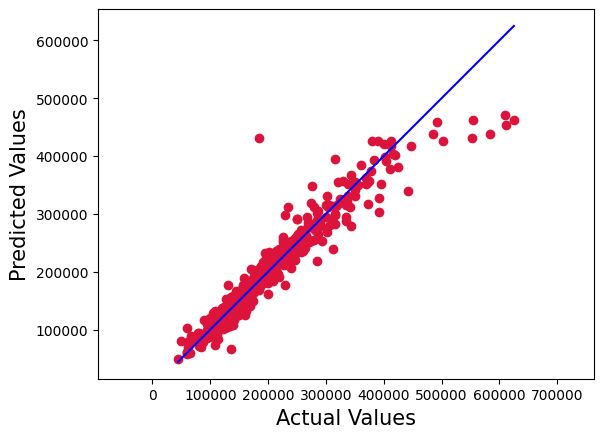

In [18]:
Actual_Price=np.expm1(y_test)
Predicted_Price=np.expm1(lgb_pred)
plt.scatter(Actual_Price, Predicted_Price, c='crimson')
p1 = max(max(Predicted_Price), max(Actual_Price))
p2 = min(min(Predicted_Price), min(Actual_Price))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

<ipython-input-19-3a24dc4c93af>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot((y_test-lgb_pred),bins=100);


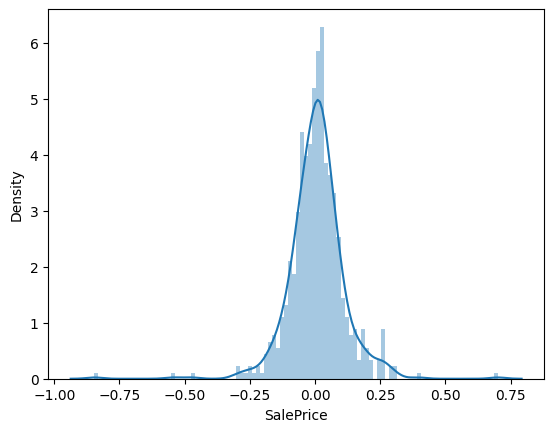

In [19]:
sb.distplot((y_test-lgb_pred),bins=100);

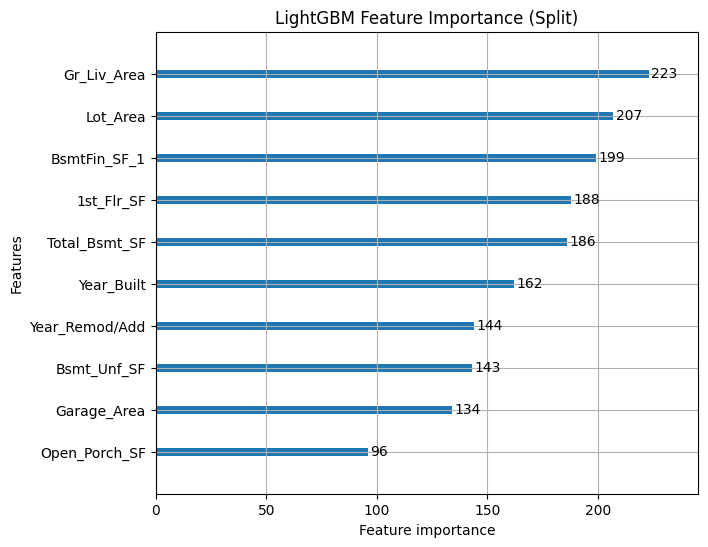

In [35]:
lgb.plot_importance(lgb_mod, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)", max_num_features= 10)
plt.show()